<a href="https://colab.research.google.com/github/starminalush/workshop-vit/blob/main/%D1%82%D1%80%D0%B0%D0%BD%D1%81%D1%84%D0%BE%D1%80%D0%BC%D0%B5%D1%80%D1%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Теория

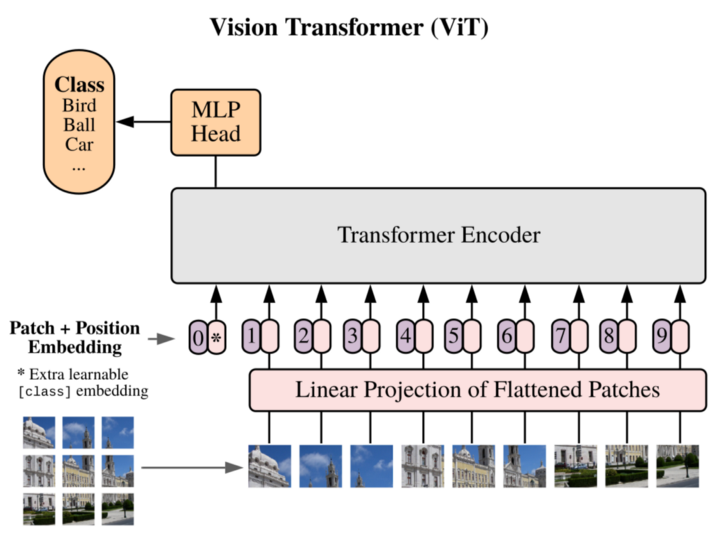

Входное изображение разбивается на 16х16 плоских участков (изображение не в масштабе). Затем они встраиваются с помощью обычного полносвязного слоя, перед ними добавляется специальный токен cls и суммируется позиционное кодирование. Полученный тензор передается сначала в стандартный преобразователь, а затем в голову классификации.

### Импорты

In [ ]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 442 kB/s 


In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary
from typing import Dict
from torchvision.datasets import ImageFolder
from torchvision import transforms
import os
from torch.utils.data import  DataLoader

Тестовая картинка

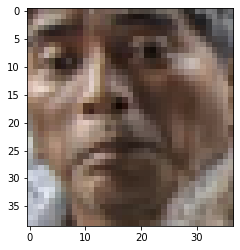

In [ ]:
img = Image.open('test.png')
plt.imshow(img)

In [ ]:
transform = Compose([Resize((224, 224)), ToTensor()])
x = transform(img)
x = x.unsqueeze(0) # add batch dim
x.shape

torch.Size([1, 3, 224, 224])

1 шаг: разбить картинку на патчи и развернуть ее

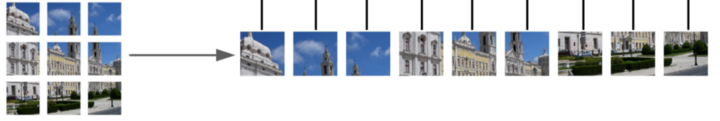

In [ ]:
patch_size = 16 # 16 pixels
patches = rearrange(x, 'b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size)

In [ ]:
patches.shape

torch.Size([1, 196, 768])

2 шаг: делаем Linear Projection, используя линейный слой

3 шаг: добавить cls token и postion embedding. Cls token это просто число, помещенное в каждую последовательность (проецируемых патчей).

4 шаг: создаем position embedding

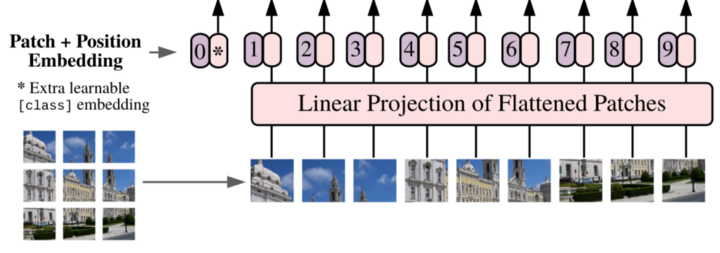

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768):
        self.patch_size=  patch_size
        super().__init__()
        self.projection = nn.Sequential(
              Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)',  s1=patch_size, s2=patch_size),
              nn.Linear(patch_size*patch_size*in_channels, emb_size)
        )
    def forward(self, x: Tensor) -> Tensor:
        x = self.projection(x)
        return x
    

### Encoder

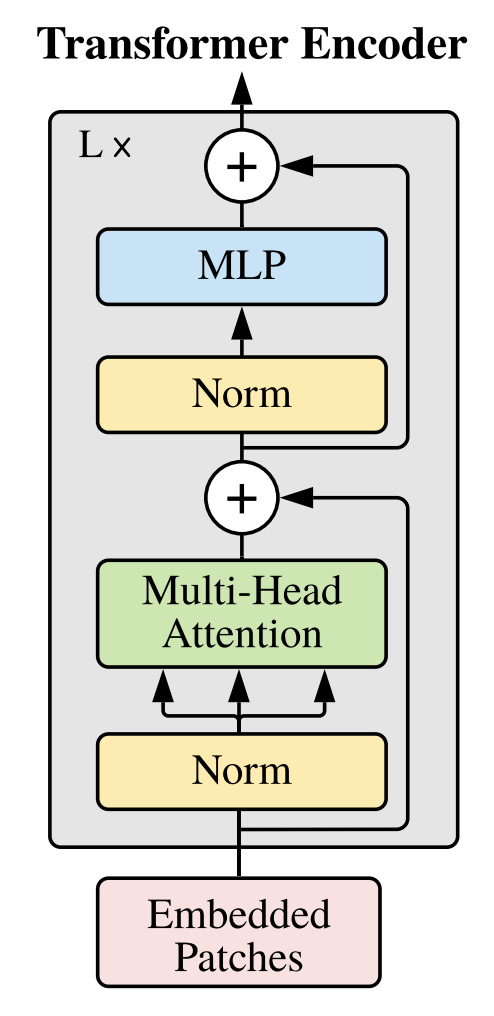

Attention Head

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 768, num_heads: int = 8, dropout: float = 0):
        #код здесь
        
    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        #код здесь
        
    

ResudialAdd

In [ ]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
        
    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

In [ ]:
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size: int, expansion: int = 4, drop_p: float = 0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

Cам Encoder

In [ ]:
class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size: int = 768,
                 drop_p: float = 0.,
                 forward_expansion: int = 4,
                 forward_drop_p: float = 0.,
                 ** kwargs):
        #код здесь

### Transformer

In [ ]:
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int = 12, **kwargs):
      #код здесь
      

SyntaxError: incomplete input (491736407.py, line 4)

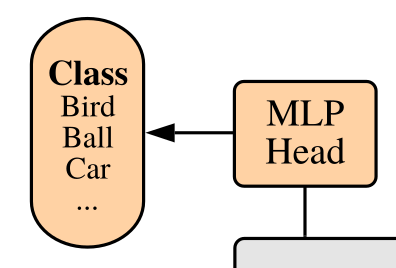

In [ ]:
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int = 768, n_classes: int = 1000):
        #ваш код здесь

In [ ]:
class ViT(nn.Sequential):
    def __init__(self,     
                in_channels: int = 3,
                patch_size: int = 16,
                emb_size: int = 768,
                img_size: int = 224,
                depth: int = 12,
                n_classes: int = 2,
                **kwargs):
        #ваш код здесь

In [ ]:
#вот это должно получиться
summary(ViT(), (3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
         Rearrange-2             [-1, 196, 768]               0
    PatchEmbedding-3             [-1, 197, 768]               0
         LayerNorm-4             [-1, 197, 768]           1,536
            Linear-5            [-1, 197, 2304]       1,771,776
           Dropout-6          [-1, 8, 197, 197]               0
            Linear-7             [-1, 197, 768]         590,592
MultiHeadAttention-8             [-1, 197, 768]               0
           Dropout-9             [-1, 197, 768]               0
      ResidualAdd-10             [-1, 197, 768]               0
        LayerNorm-11             [-1, 197, 768]           1,536
           Linear-12            [-1, 197, 3072]       2,362,368
             GELU-13            [-1, 197, 3072]               0
          Dropout-14            [-1, 19

In [ ]:
#если успеем, обучим трансформер. Если не успеем, дописать ноутбук для классификации масок